# Transfer Learning with YAMNet for environmental sound classification

YAMNet is an audio event classifier that can predict audio events from 521 classes, like laughter, barking, or a siren.

## Importing Packages

In [ ]:
!pip install -q tensorflow_io
!pip install -q livelossplot

In [ ]:
import os

from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

## Importing YAMNet and exploring it

YAMNet is a model trained on the AudioSet Dataset that has 521 classes of environmental sounds. The model accepts a 1D Numpy array or tensor of arbitrary length having mono channel 16KHz samples in the range [-1.0, 1.0]. The model returns a tuple of 3 quantities: class scores, embeddings and log mel spectrogram. 

One specific use of YAMNet is as a high-level feature extractor: the 1024-D embedding output of YAMNet can be used as the input features of another shallow model which can then be trained on a small amount of data for a particular task. This allows the quick creation of specialized audio classifiers without requiring a lot of labeled data and without having to train a large model end-to-end.

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
testing_wav_filename = tf.keras.utils.get_file('miaow_16k.wav', 'https://storage.googleapis.com/audioset/miaow_16k.wav', cache_dir='./', cache_subdir='test_data')
print(testing_wav_filename)

221184/215546 [==============================] - 0s 0us/step
./test_data/miaow_16k.wav


### Function to load audio files and convert them to the required 1D array for the input to the model.

In [ ]:
@tf.function
def load_wav_16k_mono(filename):
    # reads a .wav file and converts to a 16Khz mono array
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

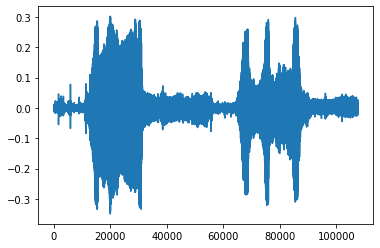

In [ ]:
testing_wav_data = load_wav_16k_mono(testing_wav_filename)
plt.plot(testing_wav_data);

#play the audio
display.Audio(testing_wav_data, rate=16000)

### Loading the class mapping

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
    print(name)
print('... upto 521 classes')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
... upto 521 classes


### Run inference on example Miaow input

In [ ]:
scores, embeddings, spectro = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print('The main sound is: {}'.format(infered_class))
print('The embeddings shape is: {}'.format(embeddings.shape))

The main sound is: Animal
The embeddings shape is: (13, 1024)


## The ESC-50 dataset

The ESC-50 dataset, well described here, is a labeled collection of 2000 environmental audio recordings (each 5 seconds long). The data consists of 50 classes, with 40 examples per class.

In [ ]:
_ = tf.keras.utils.get_file('esc-50.zip', 
                            'https://github.com/karoldvl/ESC-50/archive/master.zip',
                            cache_dir = './',
                            cache_subdir = 'datasets', extract = True)

645005312/Unknown - 42s 0us/step

In [ ]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Filtering the dataset

We need to use the embeeddings provided by the YAMNet so we shorten the ESC-50 dataset to only contain a few classes of animals. We make necessary changes in the filtering process to make the loading of the data to the model easier.

In [ ]:
my_classes = ['dog', 'cat', 'crow', 'cow', 'sheep', 'frog']
map_classes_to_id = {'dog':0, 'cat':1, 'crow':2, 'cow':3, 'sheep':4, 'frog':5}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda names: map_classes_to_id[names])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
8,./datasets/ESC-50-master/audio/1-103298-A-9.wav,1,2,crow,False,103298,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
29,./datasets/ESC-50-master/audio/1-121951-A-8.wav,1,4,sheep,False,121951,A
45,./datasets/ESC-50-master/audio/1-15689-A-4.wav,1,5,frog,False,15689,A
46,./datasets/ESC-50-master/audio/1-15689-B-4.wav,1,5,frog,False,15689,B
49,./datasets/ESC-50-master/audio/1-16568-A-3.wav,1,3,cow,False,16568,A
69,./datasets/ESC-50-master/audio/1-17970-A-4.wav,1,5,frog,False,17970,A
79,./datasets/ESC-50-master/audio/1-18755-A-4.wav,1,5,frog,False,18755,A
80,./datasets/ESC-50-master/audio/1-18755-B-4.wav,1,5,frog,False,18755,B


### Loading the audio files into the desired format

In [ ]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies embedding extraction to the wav data
def extract_embedding(wav_data, label, fold):
    scores, embeddings, spectro = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, 
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extracts the embeddings
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Splitting the data based on folds

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold<4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold==4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold==5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)
train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Creating the model

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(len(my_classes))
], name='my_model')

model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 657,670
Trainable params: 657,670
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', metrics=['accuracy'])

callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
callback = [callback1, PlotLossesKerasTF()]

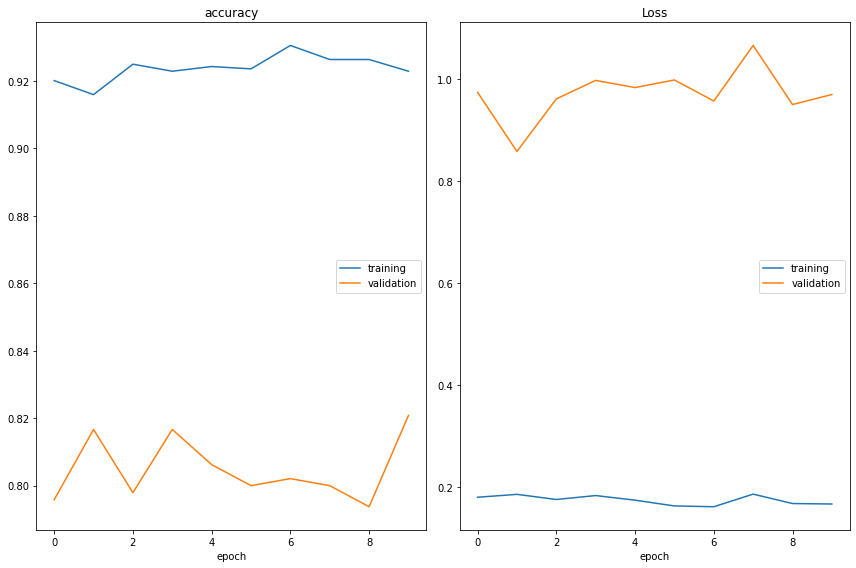

accuracy
	training         	 (min:    0.916, max:    0.931, cur:    0.923)
	validation       	 (min:    0.794, max:    0.821, cur:    0.821)
Loss
	training         	 (min:    0.161, max:    0.186, cur:    0.167)
	validation       	 (min:    0.858, max:    1.066, cur:    0.970)


In [ ]:
EPOCHS = 20
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, callbacks=callback)

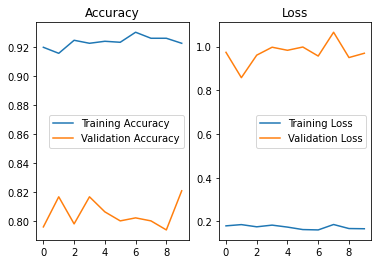

In [ ]:
plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

15/15 [==============================] - 0s 3ms/step - loss: 1.4205 - accuracy: 0.7667


In [ ]:
scores, embeddings, spectro = yamnet_model(testing_wav_data)
result = model(embeddings).numpy()

infered_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: cat


## Creating another model that takes in wav as input

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis
    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = './animals_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet_embeds')

_, embedding_op, _ = embedding_extraction_layer(input_segment)
serving_outputs = model(embedding_op)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./animals_yamnet/assets


INFO:tensorflow:Assets written to: ./animals_yamnet/assets


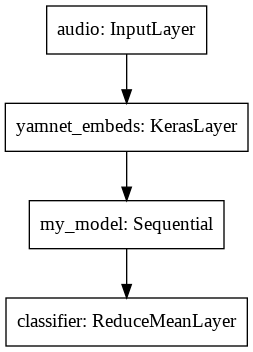

In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
which_animal = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {which_animal}')

The main sound is: cat


In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
which_animal = my_classes[tf.argmax(serving_results['classifier'])]
print(f'The main sound is: {which_animal}')

The main sound is: cat


./datasets/ESC-50-master/audio/5-198891-B-8.wav
Waveform values: [-1.2340180e-08  4.5239279e-08 -6.1851843e-08 ... -1.0108956e-01
 -7.8028627e-02 -6.8335801e-02]


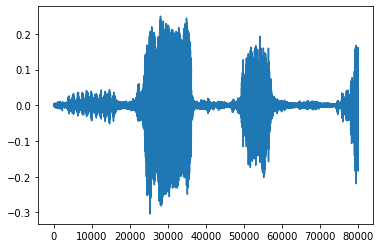

In [ ]:
test_pd = filtered_pd.loc[filtered_pd.fold == 5]
row = test_pd.sample(1)
filename = row.filename.item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [ ]:
# running the model and checking the output
scores, embedding, spectro = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'YAMNet says the main sound is: {infered_class} with confidence of {top_score}')

reloaded_results = reloaded_model(waveform)
my_top_class = tf.argmax(reloaded_results)
my_infered_class = my_classes[my_top_class]
class_probs = tf.nn.softmax(reloaded_results, axis=-1)
my_top_score = class_probs[my_top_class]
print(f'My model says the main sound is: {my_infered_class} with confidence of: {my_top_score}')

YAMNet says the main sound is: Animal with confidence of 0.6906725764274597


My model says the main sound is: sheep with confidence of: 1.0
